# Lab Assignment Five: Wide and Deep Network Architectures

In this lab, we will select a prediction task to perform on our dataset, evaluate two different deep learning architectures and tune hyper-parameters for each architecture.

## Team Members:
1) Mohammed Ahmed Abdelrazek Aboelela.

2) Naim Barnett

## Dataset Selection

Data Set : Credit Card Classification - https://www.kaggle.com/datasets/parisrohan/credit-score-classification?select=train.csv

### Overview and Business Understanding

It is very important in the work of global financial companies and also banks to have a classifier that helps them to decide whether or not to trust customers when lending them large sum of money, such as a mortgage or a line of credit. To determine said reliability of customers, companies and banks utilizes the credit score, which is dependent on a variety of factors. Within the public domain of Kaggle, there is a large database that holds information on the known factors associated with credit score, and the final given credit score bracket. It contains over 100000 datapoints, and it utilizes both numeric and categorical data. Our goal is to build an intelligent system to segregate the people into credit score brackets to reduce the manual efforts. Thus, the main prediction task here is to classify the credit score of a customer based on their credit-related attributes. This is of direct interest to third parties (such as companies) that want a tool to reduce the efforts to classify their customer's credit scores. Consequently, for the prediction algorithm to be considered useful, it needs to be very efficient when applied to our test data in predicting the credit scores of the test customers. The model (from my own understanding of the difference between online and offline analysis) will be mostly for offline analysis, meaning that the model will be trained and tested using the already provided datapoints, and then the prediction data will be collected and fed to the algorithm that will predict the respective credit score bracket.

## Preparation (4 points total)

[1 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). 

In [171]:
"""Importing all the needed packages"""
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from copy import deepcopy
import seaborn as sns
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
import re
import missingno as mn         #make sure to have the package installed "pip install missingno"
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [172]:
"""Loading the dataset"""
df_train_orig = pd.read_csv('train.csv', low_memory=False)
df_test_orig = pd.read_csv('test.csv', low_memory=False)
df_train_orig.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [173]:
data = deepcopy(df_train_orig)
test = deepcopy(df_test_orig)

From the data below, we can see the overall statistics from the raw data. Ideally, once we are done cleaning, such values as the average will become more accurate.

In [174]:
#Showing the initial form of the data and their related features and averages
data.info()
data.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

,count,mean,std,min,25%,50%,75%,max
Monthly_Inhand_Salary,84998.0,4194.170850,3183.686167,303.645417,1625.568229,3093.745000,5957.448333,15204.633333
Num_Bank_Accounts,100000.0,17.091280,117.404834,-1.000000,3.000000,6.000000,7.000000,1798.000000
Num_Credit_Card,100000.0,22.474430,129.057410,0.000000,4.000000,5.000000,7.000000,1499.000000
Interest_Rate,100000.0,72.466040,466.422621,1.000000,8.000000,13.000000,20.000000,5797.000000
Delay_from_due_date,100000.0,21.068780,14.860104,-5.000000,10.000000,18.000000,28.000000,67.000000
Num_Credit_Inquiries,98035.0,27.754251,193.177339,0.000000,3.000000,6.000000,9.000000,2597.000000
Credit_Utilization_Ratio,100000.0,32.285173,5.116875,20.000000,28.052567,32.305784,36.496663,50.000000
Total_EMI_per_month,100000.0,1403.118217,8306.041270,0.000000,30.306660,69.249473,161.224249,82331.000000


Below is a table that includes a description of each attribute in our dataset.

| ID | Customer_ID | Month | Name | Age | SSN | Occupation | Annual_Income | Monthly_Inhand_Salary | Num_Bank_Accounts | Num_Credit_Card | Interest_Rate| Num_of_Loan | Type_of_Loan | Delay_from_due_date | Num_of_Delayed_Payments | Changed_Credit_Limit | Num_Credit_Inquiries | Credit_Mix | Outstanding_Debt | Credit_Utilization_Ratio | Credit_History_Age | Payment_of_Min_Amount | Total_EMI_per_month | Amount_invested_monthy | Payment_Behaviour | Monthly_Balance | Credit_Score |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| a unique identification of an entry | a unique identification of a person | the month of the year | the name of a person | the age of the person | the social security number of the person | the occupation of the person | the annual income of the person | the monthly base salary of a person | the number of bank accounts a person holds | the number of other credit cards held by a person | the interest rate on the credit card | the number of loans taken from the bank | the types of loan taken by a person | the average number of days delayed from the payment date | the average number of payments delayed by a person | the percentage change in credit card limit | the number of credit card inquiries | the classification of the mix of credits (the types of different credit accounts) | the remaining debt to be paid (in USD) | the utilization ratio of credit card (the sum of all your balances, divided by the sum of your cards' credit limits) | the age of credit history of the person | whether only the minimum amount was paid by the person | the monthly EMI "Equated monthly installment" payments (in USD) | the monthly amount invested by the customer (in USD) | the payment behavior of the customer (in USD) | the monthly balance amount of the customer (in USD) | the bracket of credit score (Poor, Standard, Good)|

Due to the relatively big number of attributes (27 + Credit Score), we will be more inclined to get rid of some of them if: 
1) They are not relevant to our analysis.

2) They have a big number of missing data (which make it hard to do imputation).

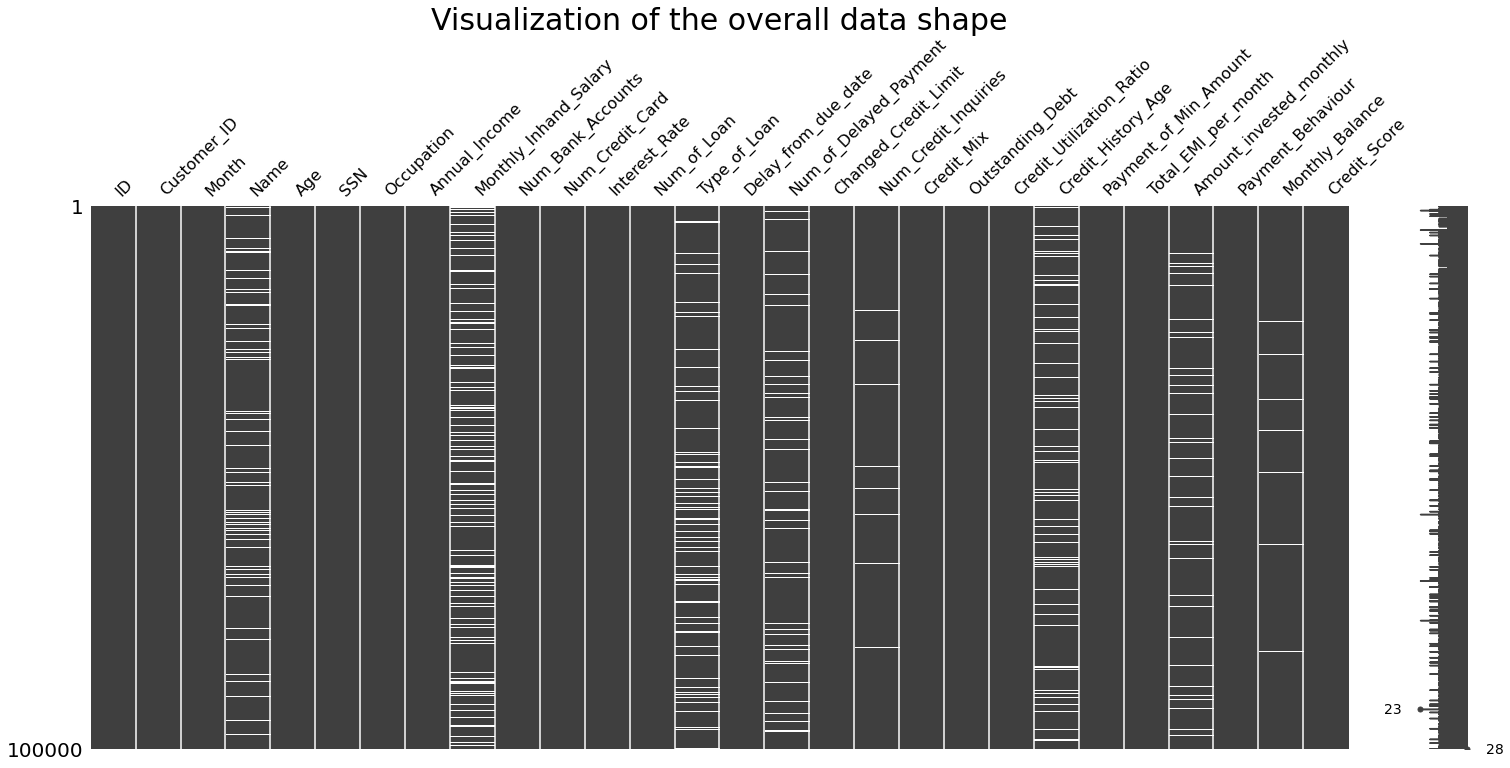

In [175]:
#Looking at the overall shape of the data
mn.matrix(data)
plt.title("Visualization of the overall data shape", fontsize=30)
plt.show()

To ensure our data maintains high quality, so our results can be as accurate as possible, we need to clean our data.

After an attempt to impute the null or unusable values, we found that it ended up skewing the values. Additionally the sheer amount of values caused overfitting in some of our calculations. Resultantly, we chose to simply remove the unusable data .

First, we are going to remove columns that are not useful to our analysis. We can see that information such as Customer_ID, Month, Name, and SSN are general information that is extremely unlikely to have any affect on the trends we are analyzing. As a result, we can remove the columns to narrow our dataset.

In [176]:
#Print column names
data.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score'],
      dtype='object')

In [177]:
#Remove Customer_ID, Name, SSN, Type_of_Loan. We remove the "Type_of_Loan" because it has broadly many unique values
#and combinations that will be very hard to trace and will more likely make it harder for the network to find a 
#pattern in training
data.drop(['ID','Customer_ID', 'Name', 'SSN', 'Type_of_Loan'], axis=1, inplace=True)
test.drop(['ID','Customer_ID', 'Name', 'SSN', 'Type_of_Loan'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Month                     100000 non-null  object 
 1   Age                       100000 non-null  object 
 2   Occupation                100000 non-null  object 
 3   Annual_Income             100000 non-null  object 
 4   Monthly_Inhand_Salary     84998 non-null   float64
 5   Num_Bank_Accounts         100000 non-null  int64  
 6   Num_Credit_Card           100000 non-null  int64  
 7   Interest_Rate             100000 non-null  int64  
 8   Num_of_Loan               100000 non-null  object 
 9   Delay_from_due_date       100000 non-null  int64  
 10  Num_of_Delayed_Payment    92998 non-null   object 
 11  Changed_Credit_Limit      100000 non-null  object 
 12  Num_Credit_Inquiries      98035 non-null   float64
 13  Credit_Mix                100000 non-null  ob

Secondly, we are going to fill null values in the columns missing data. We also want to remove any illegal values

In [178]:
#Replace Invalid Values
data =data.replace(r'[^\w\s.]|_|-', '', regex=True) 
test =test.replace(r'[^\w\s.]|_|-', '', regex=True) 
#Replace all blank strings will null to be dropped
data.replace('', np.nan, inplace=True)
test.replace('', np.nan, inplace=True)
#Remove all rows with null values
data.dropna(inplace=True);
test.dropna(inplace=True);

In [179]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48251 entries, 6 to 99999
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Month                     48251 non-null  object 
 1   Age                       48251 non-null  object 
 2   Occupation                48251 non-null  object 
 3   Annual_Income             48251 non-null  object 
 4   Monthly_Inhand_Salary     48251 non-null  float64
 5   Num_Bank_Accounts         48251 non-null  int64  
 6   Num_Credit_Card           48251 non-null  int64  
 7   Interest_Rate             48251 non-null  int64  
 8   Num_of_Loan               48251 non-null  object 
 9   Delay_from_due_date       48251 non-null  int64  
 10  Num_of_Delayed_Payment    48251 non-null  object 
 11  Changed_Credit_Limit      48251 non-null  object 
 12  Num_Credit_Inquiries      48251 non-null  float64
 13  Credit_Mix                48251 non-null  object 
 14  Outsta

Thirdly, we want to clear out all duplicate data so our frequency analysis remains accurate.

In [180]:
#Find duplicate instances
duplicates = data[data.duplicated()]
test_duplicates = test[test.duplicated()]


#Remove all duplicates
data = data.drop_duplicates()
test = test.drop_duplicates()

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48251 entries, 6 to 99999
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Month                     48251 non-null  object 
 1   Age                       48251 non-null  object 
 2   Occupation                48251 non-null  object 
 3   Annual_Income             48251 non-null  object 
 4   Monthly_Inhand_Salary     48251 non-null  float64
 5   Num_Bank_Accounts         48251 non-null  int64  
 6   Num_Credit_Card           48251 non-null  int64  
 7   Interest_Rate             48251 non-null  int64  
 8   Num_of_Loan               48251 non-null  object 
 9   Delay_from_due_date       48251 non-null  int64  
 10  Num_of_Delayed_Payment    48251 non-null  object 
 11  Changed_Credit_Limit      48251 non-null  object 
 12  Num_Credit_Inquiries      48251 non-null  float64
 13  Credit_Mix                48251 non-null  object 
 14  Outsta

Fourthly, we would like to remove outliers from out dataset, so that our data analysis isn't skewed.

In [181]:
#Determine outliers
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
#Remove outliers
data = data[~((data < (Q1 - 1.5*IQR)) | (data > (Q3 + 1.5*IQR))).any(axis = 1)]
data = data[(data['Num_Bank_Accounts'] >= 0)]

data[['Age']] = data[['Age']].apply(pd.to_numeric)
data = data.loc[(data["Age"] > 0) & (data["Age"] <= 112)] #112 is the recorded oldest age ever!

data[['Changed_Credit_Limit']] = data[['Changed_Credit_Limit']].apply(pd.to_numeric)
data = data.loc[(data["Changed_Credit_Limit"] > 0) & (data["Changed_Credit_Limit"] <= 100)] #Since it's a percentage,
#we do the selection of the instances with numbers between 0 and 100%.

data[['Monthly_Balance']] = data[['Monthly_Balance']].astype('float64')
data = data.loc[(data["Monthly_Balance"] < 10000)] #Keeping the reasonable monthly balance (value < 10000), 
#and the converting to numeric values

data = data.loc[(data["Payment_Behaviour"] != '98')] #noticed this unreasonable category thus removing it

data = data.loc[(data["Payment_of_Min_Amount"] != 'NM')] #keeping only known info about payment of min amount

data.info()

#Doing the same for the test data
Q1 = test.quantile(0.25)
Q3 = test.quantile(0.75)
IQR = Q3 - Q1
#Remove outliers
test = test[~((test < (Q1 - 1.5*IQR)) | (test > (Q3 + 1.5*IQR))).any(axis = 1)]
test = test[(test['Num_Bank_Accounts'] >= 0)]

test[['Age']] = test[['Age']].apply(pd.to_numeric)
test = test.loc[(test["Age"] > 0) & (test["Age"] <= 112)] #112 is the recorded oldest age ever!

test[['Changed_Credit_Limit']] = test[['Changed_Credit_Limit']].apply(pd.to_numeric)
test = test.loc[(test["Changed_Credit_Limit"] > 0) & (test["Changed_Credit_Limit"] <= 100)] #Since it's a percentage,
#we do the selection of the instances with numbers between 0 and 100%.

test[['Monthly_Balance']] = test[['Monthly_Balance']].astype('float64')
test = test.loc[(test["Monthly_Balance"] < 10000)] #Keeping the reasonable monthly balance (value < 10000), 
#and the converting to numeric values

test = test.loc[(test["Payment_Behaviour"] != '98')] #noticed this unreasonable category thus removing it




/var/folders/l3/2httnx650539mb_cn3qm_z80cc_3b_/T/ipykernel_35464/3503568430.py:6: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  data = data[~((data < (Q1 - 1.5*IQR)) | (data > (Q3 + 1.5*IQR))).any(axis = 1)]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 31212 entries, 6 to 99991
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Month                     31212 non-null  object 
 1   Age                       31212 non-null  int64  
 2   Occupation                31212 non-null  object 
 3   Annual_Income             31212 non-null  object 
 4   Monthly_Inhand_Salary     31212 non-null  float64
 5   Num_Bank_Accounts         31212 non-null  int64  
 6   Num_Credit_Card           31212 non-null  int64  
 7   Interest_Rate             31212 non-null  int64  
 8   Num_of_Loan               31212 non-null  object 
 9   Delay_from_due_date       31212 non-null  int64  
 10  Num_of_Delayed_Payment    31212 non-null  object 
 11  Changed_Credit_Limit      31212 non-null  float64
 12  Num_Credit_Inquiries      31212 non-null  float64
 13  Credit_Mix                31212 non-null  object 
 14  Outsta

/var/folders/l3/2httnx650539mb_cn3qm_z80cc_3b_/T/ipykernel_35464/3503568430.py:31: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  test = test[~((test < (Q1 - 1.5*IQR)) | (test > (Q3 + 1.5*IQR))).any(axis = 1)]


Fifthly, we convert all the values that unreasonably categorical into numeric for convinience.

In [182]:
"""Converting the unreasonable categorical features to numeric"""
data[['Annual_Income']] = data[['Annual_Income']].apply(pd.to_numeric)
data[['Num_of_Loan']] = data[['Num_of_Loan']].apply(pd.to_numeric)
data[['Num_of_Delayed_Payment']] = data[['Num_of_Delayed_Payment']].apply(pd.to_numeric)
data[['Outstanding_Debt']] = data[['Outstanding_Debt']].apply(pd.to_numeric)
data[['Outstanding_Debt']] = data[['Outstanding_Debt']].apply(pd.to_numeric)
data['Credit_History_Age'] = data['Credit_History_Age'].str[:2] #Keeping the year part only
data[['Credit_History_Age']] = data[['Credit_History_Age']].apply(pd.to_numeric)
data[['Amount_invested_monthly']] = data[['Amount_invested_monthly']].apply(pd.to_numeric)

test[['Annual_Income']] = test[['Annual_Income']].apply(pd.to_numeric)
test[['Num_of_Loan']] = test[['Num_of_Loan']].apply(pd.to_numeric)
test[['Num_of_Delayed_Payment']] = test[['Num_of_Delayed_Payment']].apply(pd.to_numeric)
test[['Outstanding_Debt']] = test[['Outstanding_Debt']].apply(pd.to_numeric)
test[['Outstanding_Debt']] = test[['Outstanding_Debt']].apply(pd.to_numeric)
test['Credit_History_Age'] = test['Credit_History_Age'].str[:2] #Keeping the year part only
test[['Credit_History_Age']] = test[['Credit_History_Age']].apply(pd.to_numeric)
test[['Amount_invested_monthly']] = test[['Amount_invested_monthly']].apply(pd.to_numeric)

In [183]:
data.reset_index()
test.reset_index()

,index,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,...,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
0,1,October,24,Scientist,19114.12,1824.843333,3,4,3,4,...,4.0,Good,809.98,33.053114,22,No,49.574949,21.465380,HighspentMediumvaluepayments,361.444004
1,5,October,28,Teacher,34847.84,3037.986667,2,4,6,1,...,5.0,Good,605.03,30.116600,27,No,18.816215,251.627369,LowspentLargevaluepayments,303.355083
2,9,October,35,Engineer,143162.64,12187.220000,1,5,8,3,...,3.0,Good,1303.01,35.685836,18,No,246.992319,453.615131,LowspentLargevaluepayments,788.114550
3,10,November,35,Engineer,143162.64,12187.220000,1,5,8,1381,...,5.0,Good,1303.01,31.819845,18,No,246.992319,841.232236,LowspentMediumvaluepayments,410.497445
4,12,September,55,Entrepreneur,30689.89,2612.490833,2,5,4,1,...,4.0,Good,632.46,39.377219,17,No,16.415452,69.107006,HighspentMediumvaluepayments,425.726626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17571,49977,October,21,Architect,38321.39,3106.647859,4,4,3,4,...,6.0,Good,678.57,33.817205,17,NM,362.072453,256.017961,LowspentMediumvaluepayments,245.155809
17572,49984,September,45,MediaManager,16680.35,1528.029167,1,1,5,4,...,8.0,Good,897.16,39.153349,21,No,41.113561,101.813161,LowspentMediumvaluepayments,289.876195
17573,49992,September,29,Architect,20002.88,1929.906667,10,8,29,5,...,9.0,Bad,3571.70,32.391288,6,Yes,60.964772,107.210742,LowspentSmallvaluepayments,314.815153
17574,49993,October,29,Architect,20002.88,1929.906667,10,8,29,5,...,12.0,Bad,3571.70,37.528511,6,Yes,60.964772,71.794421,LowspentSmallvaluepayments,350.231473


In [184]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31212 entries, 6 to 99991
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Month                     31212 non-null  object 
 1   Age                       31212 non-null  int64  
 2   Occupation                31212 non-null  object 
 3   Annual_Income             31212 non-null  float64
 4   Monthly_Inhand_Salary     31212 non-null  float64
 5   Num_Bank_Accounts         31212 non-null  int64  
 6   Num_Credit_Card           31212 non-null  int64  
 7   Interest_Rate             31212 non-null  int64  
 8   Num_of_Loan               31212 non-null  int64  
 9   Delay_from_due_date       31212 non-null  int64  
 10  Num_of_Delayed_Payment    31212 non-null  int64  
 11  Changed_Credit_Limit      31212 non-null  float64
 12  Num_Credit_Inquiries      31212 non-null  float64
 13  Credit_Mix                31212 non-null  object 
 14  Outsta

Our clean data then becomes: 

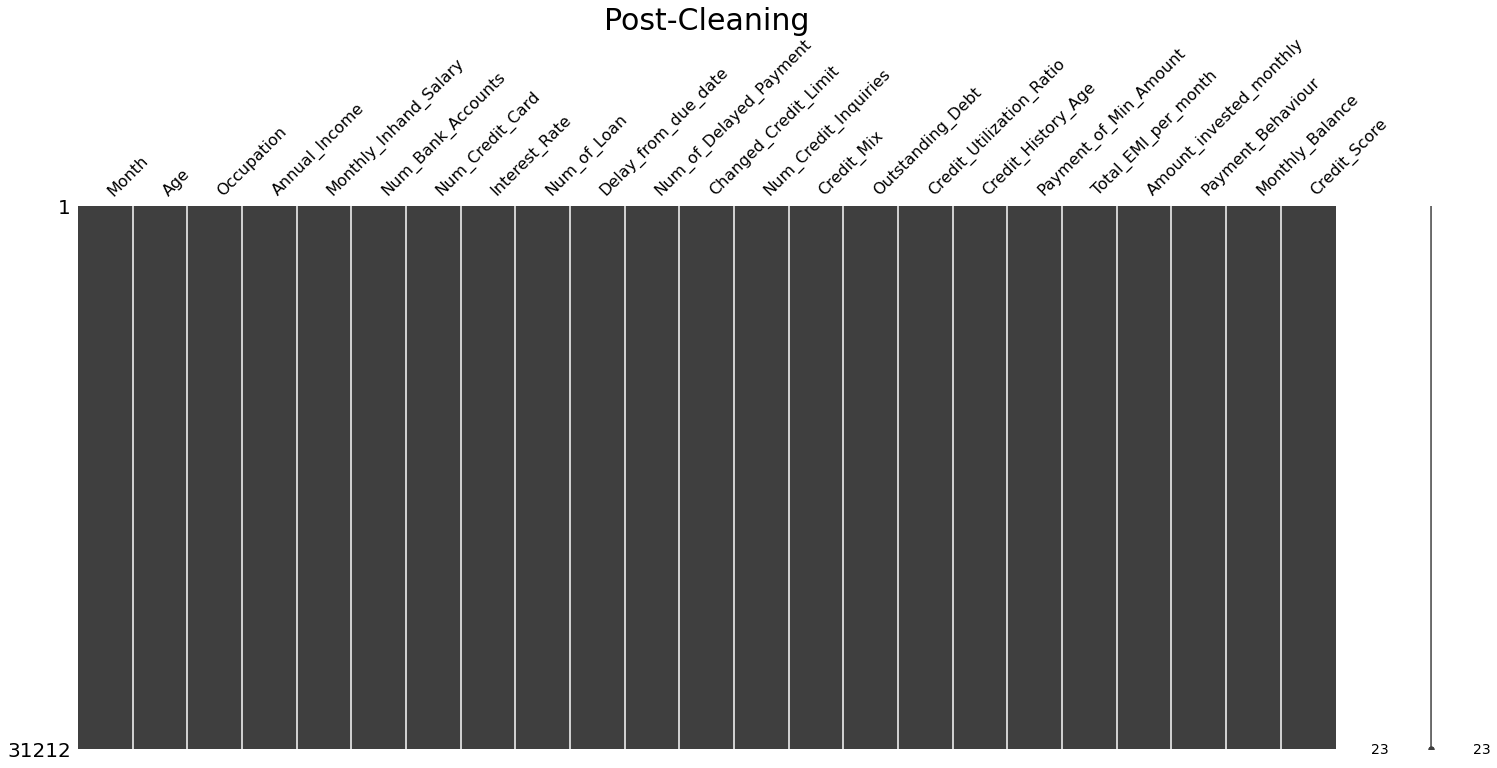

In [185]:
mn.matrix(data)
plt.title("Post-Cleaning", fontsize=30)
plt.show()

In [186]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,31212.0,33.448193,1.085276e+01,14.000000,24.000000,33.000000,42.000000,1.000000e+02
Annual_Income,31212.0,180542.282108,1.468051e+06,7005.930000,19148.930000,35544.225000,68948.320000,2.419806e+07
Monthly_Inhand_Salary,31212.0,3906.756221,2.855226e+03,303.645417,1599.524045,2948.605833,5633.435000,1.237682e+04
Num_Bank_Accounts,31212.0,5.307766,2.552675e+00,0.000000,3.000000,5.000000,7.000000,1.100000e+01
Num_Credit_Card,31212.0,5.482090,2.027122e+00,0.000000,4.000000,5.000000,7.000000,1.100000e+01
Interest_Rate,31212.0,14.198610,8.560695e+00,1.000000,7.000000,13.000000,20.000000,3.400000e+01
Num_of_Loan,31212.0,10.706203,6.223238e+01,0.000000,2.000000,3.000000,5.000000,1.480000e+03
Delay_from_due_date,31212.0,19.679578,1.289328e+01,-5.000000,10.000000,17.000000,27.000000,5.500000e+01
Num_of_Delayed_Payment,31212.0,31.739876,2.327606e+02,0.000000,9.000000,14.000000,18.000000,4.397000e+03
Changed_Credit_Limit,31212.0,10.437920,6.537392e+00,0.010000,5.470000,9.470000,14.680000,3.629000e+01


Checking categorical variables, grouping them and also grouping the numerical ones together

In [187]:
categorical_vars = []
numerical_vars = []
for column in data.columns:
    if data[column].dtype == 'object':
        categorical_vars.append(column)
    else:
        numerical_vars.append(column)
        
print("The categorical variables in our cleaned dataset are:", categorical_vars)
print("The numerical variables in our cleaned dataset are:", numerical_vars)

The categorical variables in our cleaned dataset are: ['Month', 'Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour', 'Credit_Score']
The numerical variables in our cleaned dataset are: ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance']


Performing the usual standard scaling on numerical features.

In [188]:
ss = StandardScaler()
data[numerical_vars] = ss.fit_transform(data[numerical_vars].values)
test[numerical_vars] = ss.transform(test[numerical_vars].values)
data.head()

,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
6,July,-0.962738,Scientist,-0.109963,-0.729170,-0.904072,-0.731142,-1.308163,-0.107762,-1.293685,...,Good,-0.501653,-1.918360,0.457913,No,-0.459180,-0.214063,LowspentSmallvaluepayments,-0.768761,Good
9,February,-0.502018,Teacher,-0.099245,-0.304278,-1.295825,-0.731142,-0.957719,-0.155970,-0.983441,...,Good,-0.685087,1.240930,0.946271,No,-0.848516,-0.282379,HighspentLargevaluepayments,0.453026,Good
12,May,-0.502018,Teacher,-0.099245,-0.304278,-1.295825,-0.731142,-0.957719,-0.155970,-1.293685,...,Good,-0.685087,0.536014,0.946271,No,-0.848516,-0.237947,LowspentSmallvaluepayments,0.250820,Good
13,June,-0.502018,Teacher,-0.099245,-0.304278,-1.295825,-0.731142,-0.957719,-0.155970,-1.293685,...,Good,-0.685087,0.220961,1.068360,No,-0.848516,-0.280850,HighspentLargevaluepayments,0.437317,Good
15,August,-0.502018,Teacher,-0.099245,-0.304278,-1.295825,-0.731142,-0.957719,-0.155970,-1.293685,...,Good,-0.685087,0.132741,1.068360,No,-0.848516,-0.193978,LowspentSmallvaluepayments,-0.201136,Good


In [189]:
"""Creating a heatmap to see which numerical variables are mostly correlated to help in dimensionality reduction (if we will do it)"""
#sns.heatmap(data.corr(),annot=True)
#plt.show()

'Creating a heatmap to see which numerical variables are mostly correlated to help in dimensionality reduction (if we will do it)'

Since the categorical values in credit score, credit mix and payment of min amount can be considered ordinal ones. We encode them manually, however, the ones in month, occupation and payment behaviour are nominal ones and we use normal one-hot encoding for them.

In [190]:
data['Credit_Score'].replace({"Poor":0, "Standard":1, "Good":2}, inplace=True)
data['Credit_Mix'].replace({"Bad":0, "Standard":1, "Good":2}, inplace=True)
data['Payment_of_Min_Amount'].replace({"Yes":1, "No":0}, inplace=True)
data = pd.get_dummies(data, columns = ['Month','Occupation', 'Payment_Behaviour'])

test['Credit_Mix'].replace({"Bad":0, "Standard":1, "Good":2}, inplace=True)
test['Payment_of_Min_Amount'].replace({"Yes":1, "No":0}, inplace=True)
test = pd.get_dummies(test, columns = ['Month','Occupation', 'Payment_Behaviour'])

In [192]:
data.head()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,...,Occupation_Musician,Occupation_Scientist,Occupation_Teacher,Occupation_Writer,Payment_Behaviour_HighspentLargevaluepayments,Payment_Behaviour_HighspentMediumvaluepayments,Payment_Behaviour_HighspentSmallvaluepayments,Payment_Behaviour_LowspentLargevaluepayments,Payment_Behaviour_LowspentMediumvaluepayments,Payment_Behaviour_LowspentSmallvaluepayments
6,-0.962738,-0.109963,-0.729170,-0.904072,-0.731142,-1.308163,-0.107762,-1.293685,-0.101994,0.127282,...,0,1,0,0,0,0,0,0,0,1
9,-0.502018,-0.099245,-0.304278,-1.295825,-0.731142,-0.957719,-0.155970,-0.983441,-0.132069,-0.461647,...,0,0,1,0,1,0,0,0,0,0
12,-0.502018,-0.099245,-0.304278,-1.295825,-0.731142,-0.957719,-0.155970,-1.293685,-0.132069,-0.614616,...,0,0,1,0,0,0,0,0,0,1
13,-0.502018,-0.099245,-0.304278,-1.295825,-0.731142,-0.957719,-0.155970,-1.293685,-0.136365,-0.767584,...,0,0,1,0,1,0,0,0,0,0
15,-0.502018,-0.099245,-0.304278,-1.295825,-0.731142,-0.957719,-0.155970,-1.293685,-0.119180,-0.767584,...,0,0,1,0,0,0,0,0,0,1


In [193]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31212 entries, 6 to 99991
Data columns (total 49 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Age                                             31212 non-null  float64
 1   Annual_Income                                   31212 non-null  float64
 2   Monthly_Inhand_Salary                           31212 non-null  float64
 3   Num_Bank_Accounts                               31212 non-null  float64
 4   Num_Credit_Card                                 31212 non-null  float64
 5   Interest_Rate                                   31212 non-null  float64
 6   Num_of_Loan                                     31212 non-null  float64
 7   Delay_from_due_date                             31212 non-null  float64
 8   Num_of_Delayed_Payment                          31212 non-null  float64
 9   Changed_Credit_Limit                   

Thus, the final pre-processed clean dataset we have consists of 31,212 instances. It has 17 numerical features that are ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance'] and 5 categorical ones ['Month', 'Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']. The task is to perform a classification and predict the target variable that is ['Credit_Score'], the target variable has 3 possible classes, {"Poor":0, "Standard":1, "Good":2}. 

[1 points] Identify groups of features in your data that should be combined into cross-product featues. Provide justification for why these features should be crossed (or why some features should not be crossed). 

[1 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

[1 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Argue why your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

## Modeling (5 points total)

[2 points] Create at least three combined wide and deep networks to classify your data using Keras. Visualize the performance of the network on the training data and validation data in the same plot versus the training iterations. Note: use the "history" return parameter that is part of Keras "fit" function to easily access this data.

[2 points] Investigate generalization performance by altering the number of layers in the deep branch of the network. Try at least two different number of layers. Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab to select the number of layers that performs superiorly. 

[1 points] Compare the performance of your best wide and deep network to a standard multi-layer perceptron (MLP). Alternatively, you can compare to a network without the wide branch (i.e., just the deep network). 

## Exceptional Work (1 points total)

5000 students: You have free rein to provide additional analyses.

One idea (required for 7000 level students): For classification tasks, compare using the receiver operating characteristic and area under the curve. For regression tasks, use Bland-Altman plots and residual variance calculations.  Use proper statistical methods to compare the performance of different models.